# Analyzing the energy budget of Siberia
What is it like normally? What changed in 2020?

Maybe should do bar chart like in England et. al. paper about MHWs

In [1]:
import numpy as np
import os
import pandas as pd
import xarray as xr
import cartopy
import seaborn as sns
import matplotlib as mpl
import matplotlib.colors as mcolors
import math
import calendar
from matplotlib import pyplot as plt
from scipy import stats, signal

import stats_mca_gemini as smg
import plot_mca as plt_mca

# open and preprocess data

In [2]:
# Grab the land-sea mask from the temperature dataset
path = "../../data0/yvu/ERA5/"
file = "era5_singlelvl_monthly_temperature.nc"

ds = xr.open_dataset(path+file)
ds = ds.rename({"valid_time":"time"})
ds = ds.sel(time=slice("1979","2024"))
lsm = ds.lsm.drop_vars('number')

In [3]:
# grab snowmelt and soil moisture
land = xr.open_dataset(path+'data_stream-moda_stepType-avgad.nc')#, combine='by_coords',data_vars=['swvl1'], 
                  # combine_attrs='override',chunks={})
land = land.drop_vars(['number','expver'])
land = land.rename({"valid_time":"time"})
land = land.sel(time=slice("1979","2024"))

In [4]:
land

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 552, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1979-01-01T06:00:00 ... 2024-12-01T0...
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    smlt       (time, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-21T18:54 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
# calculate ERA5 (observed) averages
path = "../../data0/yvu/ERA5/"
file = "era5_singlelvl_monthly_surfaceenergy.nc"

ds = xr.open_dataset(path+file)
ds = ds.rename({"valid_time":"time"})
weights = np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"
ds = ds.drop_vars(['number','expver'])
ds = ds.sel(time=slice("1979","2024"))

In [6]:
# flip the sign of sensible and latent heat flux so that positive is upward
# apply land-sea mask
ds['avg_ishf']=-ds.avg_ishf * lsm.values
ds['avg_slhtf']=-ds.avg_slhtf * lsm.values
avg_suswrf = -(ds.avg_snswrf - ds.avg_sdswrf) # positve upward

In [7]:
ds['avg_suswrf'] = avg_suswrf
ds = xr.merge([land,ds])

In [9]:
xr.merge([land,ds])

<xarray.Dataset> Size: 28GB
Dimensions:       (time: 552, latitude: 721, longitude: 1440)
Coordinates:
  * time          (time) datetime64[ns] 4kB 1979-01-01T06:00:00 ... 2024-12-0...
  * latitude      (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude     (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
Data variables:
    smlt          (time, latitude, longitude) float32 2GB 0.0 0.0 ... 0.0 0.0
    avg_ishf      (time, latitude, longitude) float32 2GB -0.0 -0.0 ... -4.146
    avg_slhtf     (time, latitude, longitude) float32 2GB 0.0 0.0 ... 0.01709
    avg_sdswrf    (time, latitude, longitude) float32 2GB ...
    avg_sdlwrf    (time, latitude, longitude) float32 2GB ...
    avg_snswrf    (time, latitude, longitude) float32 2GB ...
    avg_snlwrf    (time, latitude, longitude) float32 2GB ...
    avg_snswrfcs  (time, latitude, longitude) float32 2GB ...
    avg_snlwrfcs  (time, latitude, longitude) float32 2GB ...
    avg_sdswrfcs  (time, latitude, longitude) float32 2GB ...
    avg_sdlwrfcs  (time, latitude, longitude) float32 2GB ...
    avg_suswrf    (time, latitude, longitude) float32 2GB -1e-15 ... 373.5
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-21T18:54 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
var_list=['swvl1',
 'smlt',
 'avg_ishf',
 'avg_slhtf',
 'avg_sdswrf',
 'avg_sdlwrf',
 'avg_snswrf',
 'avg_suswrf',
         ]

# look at evolution of energy budget terms in 2020

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.


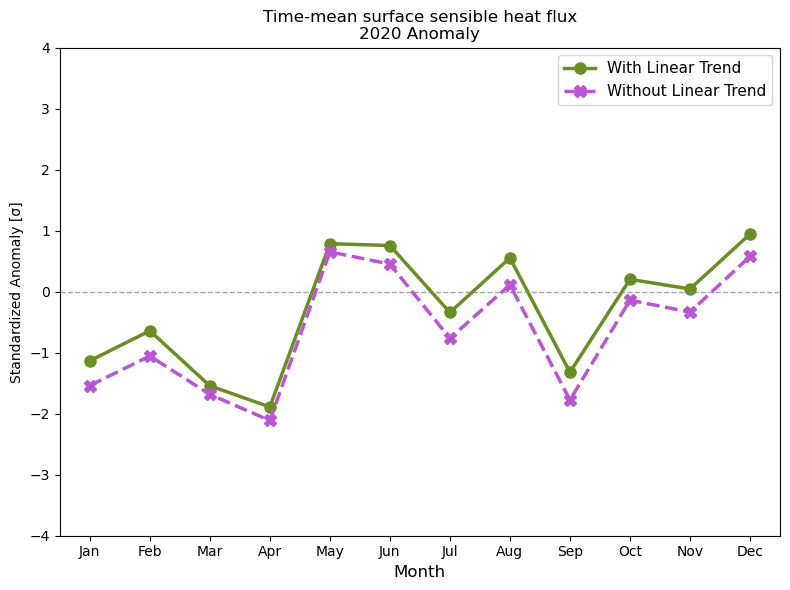

In [ ]:
## OBSERVATIONAL
# With Linear trend
kwargs={
    "region":smg.siberia,
    "month_start":1,
    "month_end":12,
    "var":'avg_ishf'
    }

# ERA5
era5_anom, era5_anomstd, era5_anomdetrend, era5_anomdetrendstd, _ = smg.calculate_detrended_stats(ds, **kwargs)
p1 = era5_anomstd.sel(time="2020")
p2 = era5_anomdetrendstd.sel(time="2020")

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title(f"{era5_anomstd.long_name}\n2020 Anomaly")
plt_mca.plot_2020_anomaly(p1, p2, ax=ax, standardized=True)
plt.tight_layout()
plt.show()

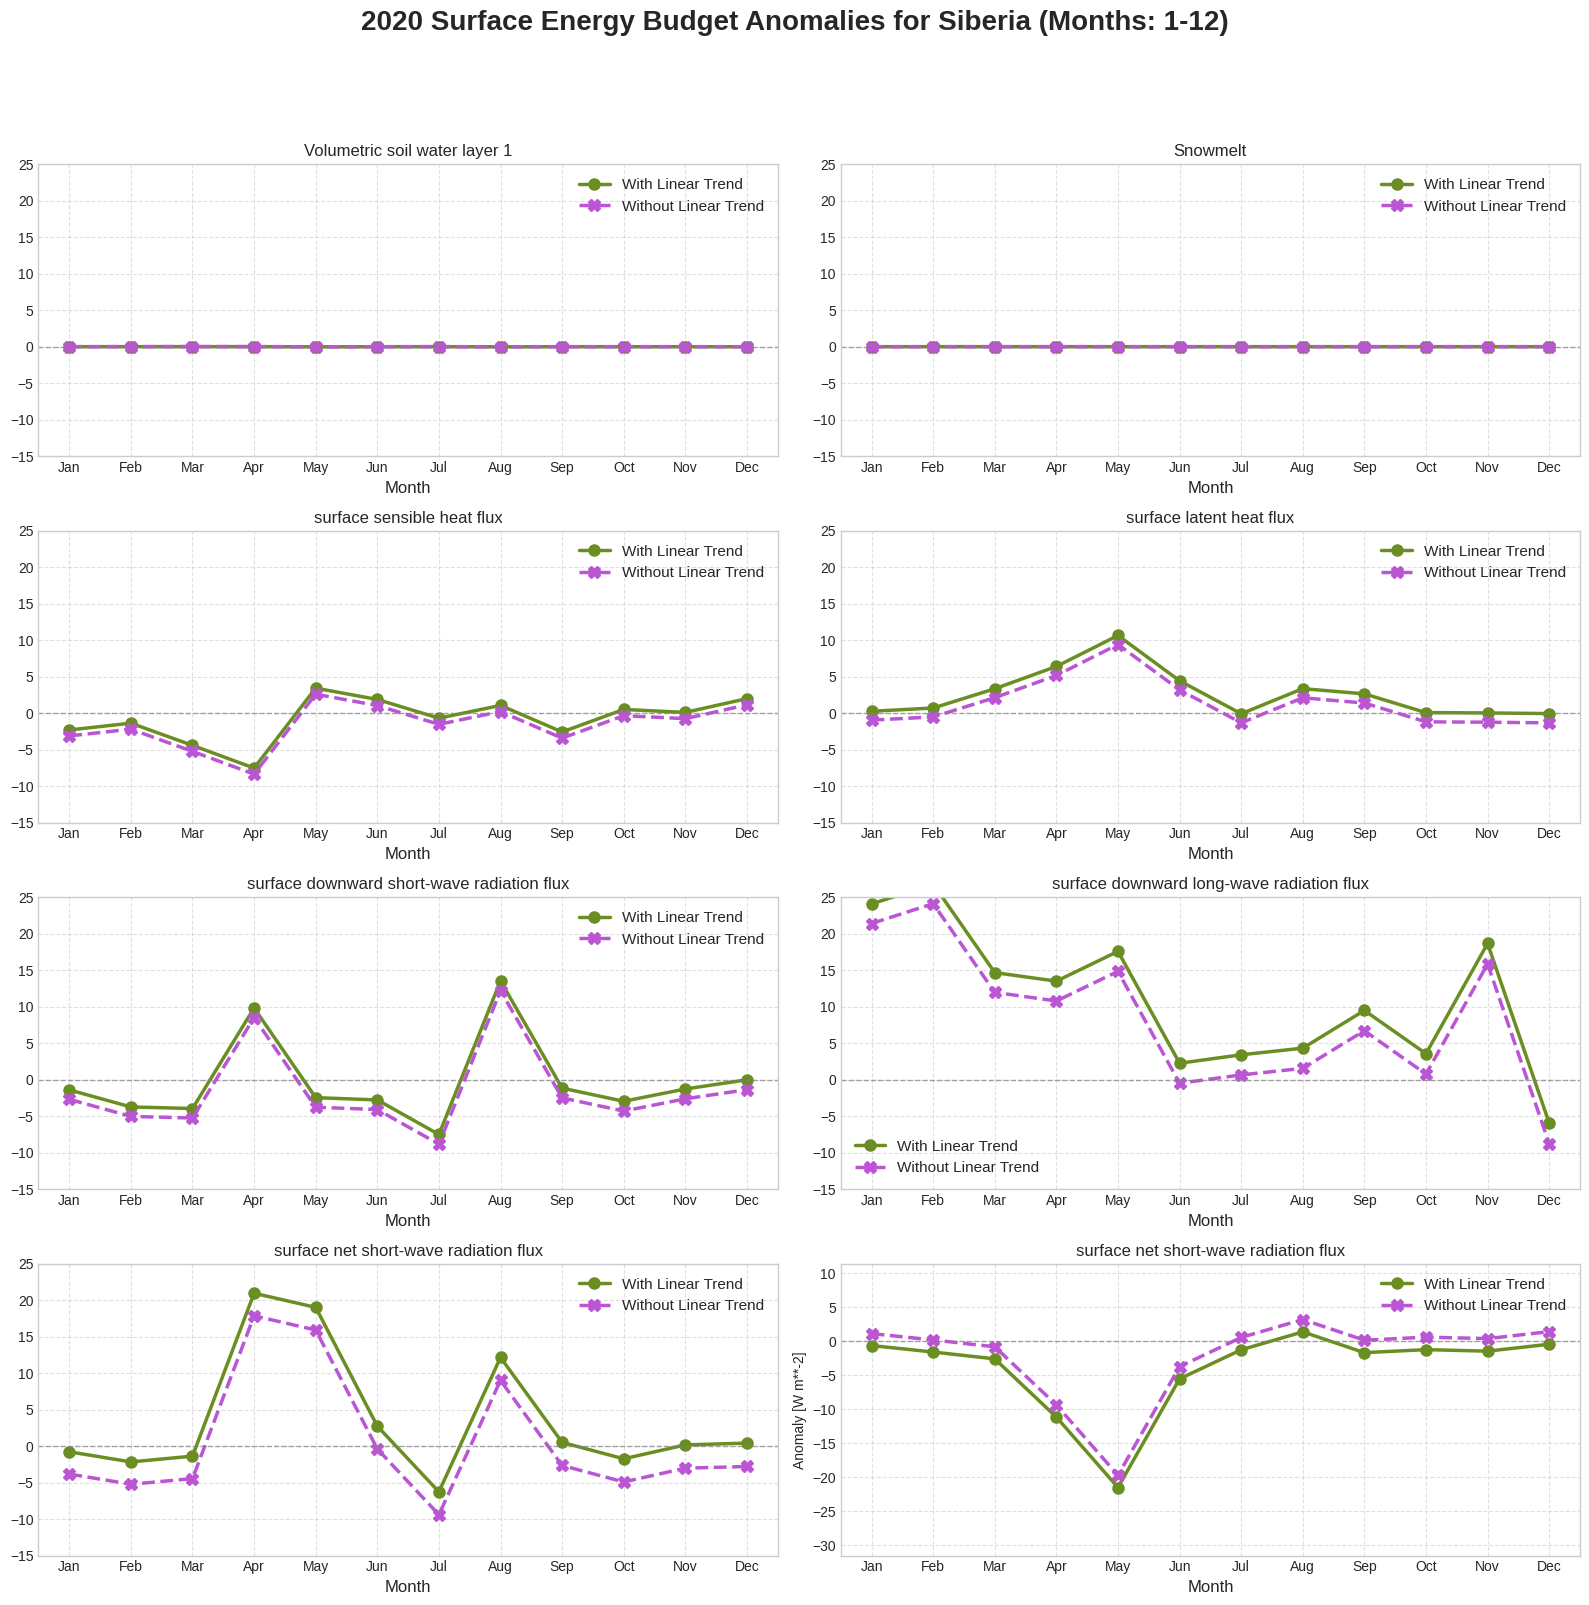

In [ ]:
# Settings
kwargs={
    "region":smg.siberia,
    "month_start":1,
    "month_end":12,
    "var":'avg_ishf'
    }

# avg_suswrf = -(ds.avg_snswrf - ds.avg_sdswrf) # positve upward

# var_list=list(ds.keys()) # Select all variables
# var_list = var_list[:-4]
# Set up figure based on number variables to plot (but keep two columns)
num_vars = len(var_list)
ncols = 2
nrows = math.ceil(num_vars / ncols)
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 4 * nrows))
axes = axes.flatten()

for i, var in enumerate(var_list):
    # Calculations which loop over every variable
    kwargs['var'] = var
    era5_anom, era5_anomstd, era5_anomdetrend, era5_anomdetrendstd, _ = smg.calculate_detrended_stats(ds, supress=True, **kwargs)
    p1 = era5_anom.sel(time="2020")
    p2 = era5_anomdetrend.sel(time="2020")
    
    # # Plot
    ax = axes[i]
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_title(ds[var].attrs['long_name'].removeprefix('Time-mean '), wrap=True)
    plt_mca.plot_2020_anomaly(p1, p2, ax=ax)
    # ax.set_ylim((p1.min()-10, p1.max()+10))

# --- 4. Final Figure Cleanup ---
for i in range(num_vars, len(axes)):
    fig.delaxes(axes[i])

# Generate a dynamic title based on the selection
region_name = kwargs['region']['name'] if kwargs['region']['name'] else "Global"
season_name = f"Months: {kwargs['month_start']}-{kwargs['month_end']}"
fig.suptitle(f"2020 Surface Energy Budget Anomalies for {region_name} (Months: {kwargs['month_start']}-{kwargs['month_end']})\n", fontsize=20, weight='bold', y=1.0)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

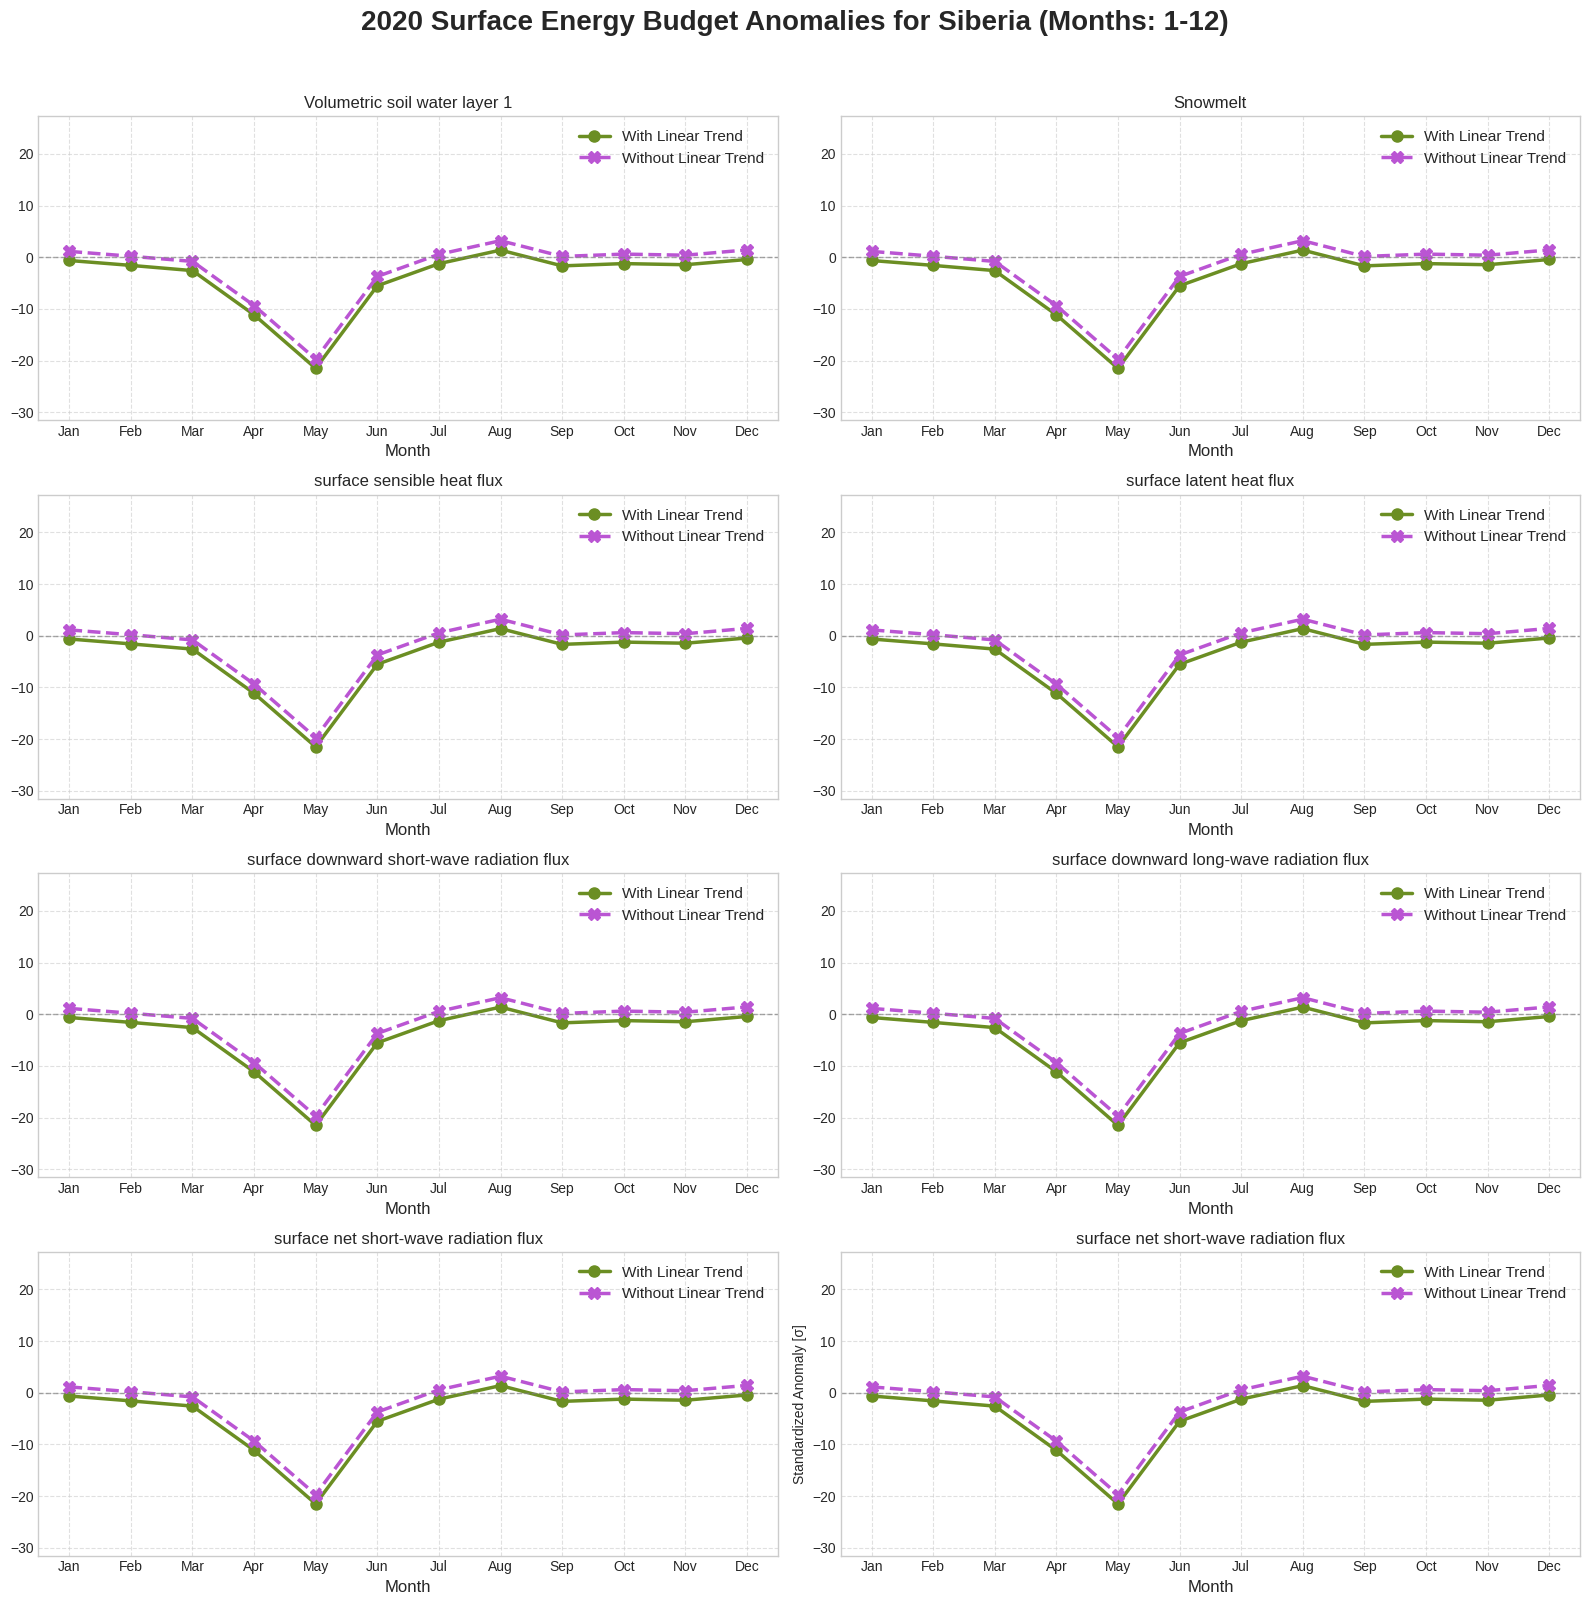

In [ ]:
num_vars = len(var_list)
ncols = 2
nrows = math.ceil(num_vars / ncols)
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 4 * nrows))
axes = axes.flatten()

for i, var in enumerate(var_list):
# Plot
    ax = axes[i]
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_title(ds[var].attrs['long_name'].removeprefix('Time-mean '), wrap=True)
    plt_mca.plot_2020_anomaly(era5_anom.sel(time="2020"), era5_anomdetrend.sel(time="2020"), ax=ax, standardized=True)
    ax.set_ylim(era5_anom.min()-10, era5_anom.max()+10)
# --- 4. Final Figure Cleanup ---
for i in range(num_vars, len(axes)):
    fig.delaxes(axes[i])

# Generate a dynamic title based on the selection
region_name = kwargs['region']['name'] if kwargs['region']['name'] else "Global"
season_name = f"Months: {kwargs['month_start']}-{kwargs['month_end']}"
fig.suptitle(f"2020 Surface Energy Budget Anomalies for {region_name} (Months: {kwargs['month_start']}-{kwargs['month_end']})\n", fontsize=20, weight='bold', y=1.0)
plt.tight_layout()
plt.show()

# surface energy budget climatologies

In [6]:
ds.data_vars

Data variables:
    t2m      (time, latitude, longitude) float32 2GB ...
    sst      (time, latitude, longitude) float32 2GB ...
    lsm      (time, latitude, longitude) float32 2GB ...

In [9]:
# --- USER SELECTION ---
# Choose the region and time period you want to analyze here.
target_region = smg.siberia  # e.g., siberia, eurasia, arctic, or None for global
month_start = 1         # Start month (e.g., 12 for December)
month_end = 12            # End month (e.g., 2 for February)
# --- END USER SELECTION ---

# Apply the region and time selection
ds_sub = smg.select_region_and_time(
    ds,
    region=target_region,
    month_start=month_start,
    month_end=month_end
)

# --- 2. Setup the Figure and Subplots ---

num_vars = len(var_list)
ncols = 2
nrows = math.ceil(num_vars / ncols)

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 4 * nrows))
axes = axes.flatten()

# --- 3. Loop Through Variables and Plot Climatology ---
for i, var_name in enumerate(var_list):
    ax = axes[i]
    
    heatwave = ds_sub[var_name].sel(time=ds_sub.time.dt.year == 2020)
    heatwave = heatwave.weighted(weights).mean(dim=('longitude', 'latitude'))
    climatology = ds_sub[var_name].groupby('time.month').mean(dim='time')
    climatology = climatology.weighted(weights).mean(dim=('longitude', 'latitude'))
    
    long_name = climatology.attrs.get('long_name', var_name)
    units = climatology.attrs.get('units', '')
    
    ax.plot(climatology.month, climatology.values, label="Climatology", marker='o', linestyle='-', color='darkcyan')
    ax.plot(heatwave.time.dt.month, heatwave.values, label="2020", marker='s', linestyle='--', color='crimson')
    
    ax.set_title(f'{long_name}', fontsize=12, weight='bold')
    ax.set_ylabel(f'{units}', fontsize=10)
    ax.set_xlabel('Month', fontsize=10)
    
    month_labels = [calendar.month_abbr[m] for m in climatology.month.values]
    ax.set_xticks(ticks=climatology.month.values)
    ax.set_xticklabels(month_labels, rotation=45)
    ax.grid(True, linestyle='--', alpha=0.6)
    if i == len(var_list) - 1:
        ax.set_title('surface upward radiation flux')

# --- 4. Final Figure Cleanup ---
for i in range(num_vars, len(axes)):
    fig.delaxes(axes[i])

# Generate a dynamic title based on the selection
region_name = target_region['name'] if target_region else "Global"
season_name = f"Months: {month_start}-{month_end}"
fig.suptitle(f'Monthly Climatology for {region_name} ({season_name})', fontsize=20, weight='bold', y=1.0)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.


NameError: name 'var_list' is not defined

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.


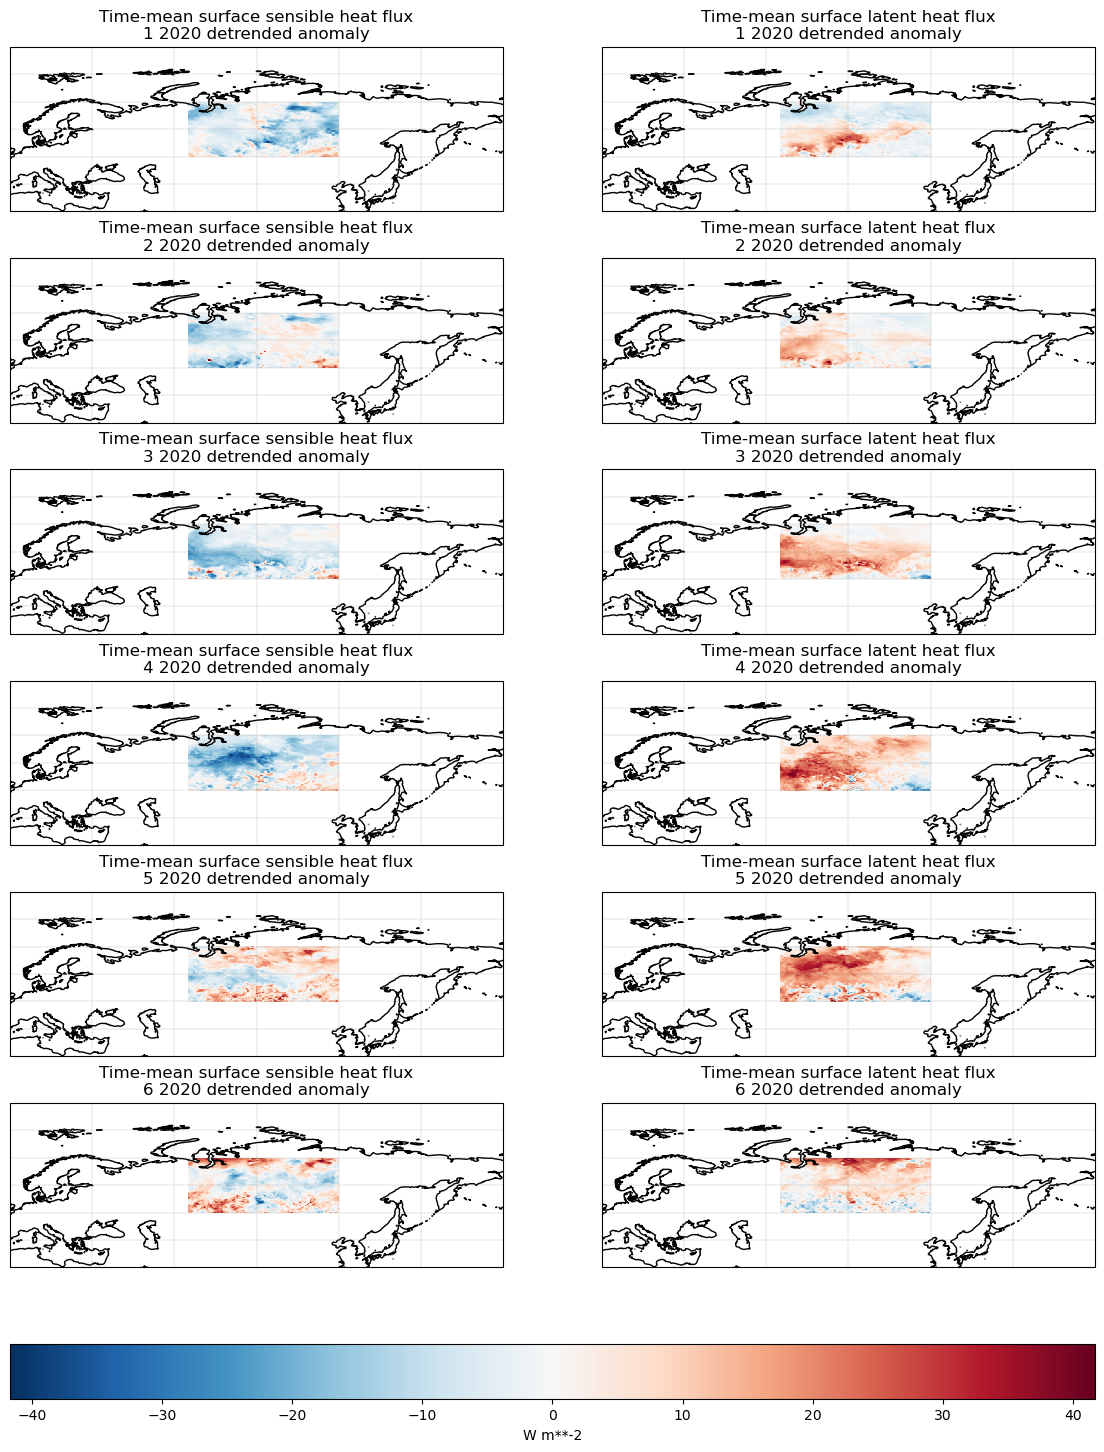

In [40]:
# Plot spatial maps of the 2020 detrended anomaly for sensible and latent heat flux over Siberia
proj = cartopy.crs.PlateCarree()
vars_to_plot = ['avg_ishf', 'avg_slhtf']  # sensible, latent
fig, axes = plt.subplots(6, 2, figsize=(14, 20), subplot_kw={'projection': proj})

month_list = np.arange(1,7)
for i, month in enumerate(month_list):
    for j, var in enumerate(vars_to_plot):
        ax = axes[i,j]
        ds_sub = ds[var]
        kwargs = {"region": smg.siberia, "month_start": 1, "month_end": 6}
        ds_regional = smg.select_region_and_time(ds_sub, **kwargs)
        
        # 2. Apply latitude weighting for accurate spatial averaging
        # 3. Calculate anomalies
        gb = ds_regional.groupby('time.month')
        clim = gb.mean(dim='time')
        anom_full = gb - clim
        anom_full = anom_full.drop_vars('month')
        p2020 = anom_full.sel(time="2020-"+str(month)).mean(dim='time')
        
        # symmetric color scale around zero
        vmax = np.nanmax(np.abs(p2020.values))
        im = p2020.plot.pcolormesh(
            ax=ax,
            transform=proj,
            cmap='RdBu_r',
            vmin=-vmax,
            vmax=vmax,
            add_colorbar=False
        )
        
        ax.coastlines(resolution='50m')
        ax.set_extent(
            [0, 180, 30, 90],
            crs=proj
        )
        ax.set_title(f"{ds[var].attrs.get('long_name', var)}\n{month} 2020 detrended anomaly")
        ax.gridlines(draw_labels=False, linewidth=0.3, color='gray', alpha=0.5)

# common colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.05)
cbar.set_label(ds[vars_to_plot[0]].attrs.get('units', ''))

# ax.tight_layout()
plt.show()

In [32]:
p2020

<xarray.DataArray 'avg_ishf' (time: 1, latitude: 81, longitude: 221)> Size: 72kB
array([[[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
         -4.7841320e+00, -4.4489956e+00, -4.2213535e+00],
        [ 0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
         -4.3578911e+00, -3.7341290e+00, -2.8414268e+00],
        [-1.3722050e+00, -4.2060769e-01, -1.2837120e-03, ...,
         -3.4713535e+00, -2.5428543e+00, -1.6199608e+00],
        ...,
        [ 2.7160349e+00,  3.1871052e+00,  3.7633238e+00, ...,
          3.9161727e+00,  2.7791061e+00,  2.3625464e+00],
        [ 2.4363022e+00,  2.8889418e+00,  3.2236767e+00, ...,
          4.3902340e+00,  2.7779083e+00,  1.4962082e+00],
        [ 1.4280291e+00,  2.1485195e+00,  2.4815035e+00, ...,
          6.1252766e+00,  4.5053234e+00,  1.5006239e+00]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 8B 2020-01-01T06:00:00
  * latitude   (latitude) float64 648B 70.0 69.75 69.5 69.25 ... 50.5 50.25 50.0
  * longitude  (longitude) float64 2kB 65.0 65.25 65.5 ... 119.5 119.8 120.0
Attributes: (12/32)
    GRIB_paramId:                             235033
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgad
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               W m**-2
    long_name:                                Time-mean surface sensible heat...
    units:                                    W m**-2
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [ ]:
heatwave.values-climatology.values

array([ -0.63324139,  -1.58059298,  -2.58821715, -11.14056634,
       -21.49461584,  -5.52335542,  -1.25134368,   1.37804339,
        -1.67557196,  -1.23085616,  -1.45330072,  -0.43634549])

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.


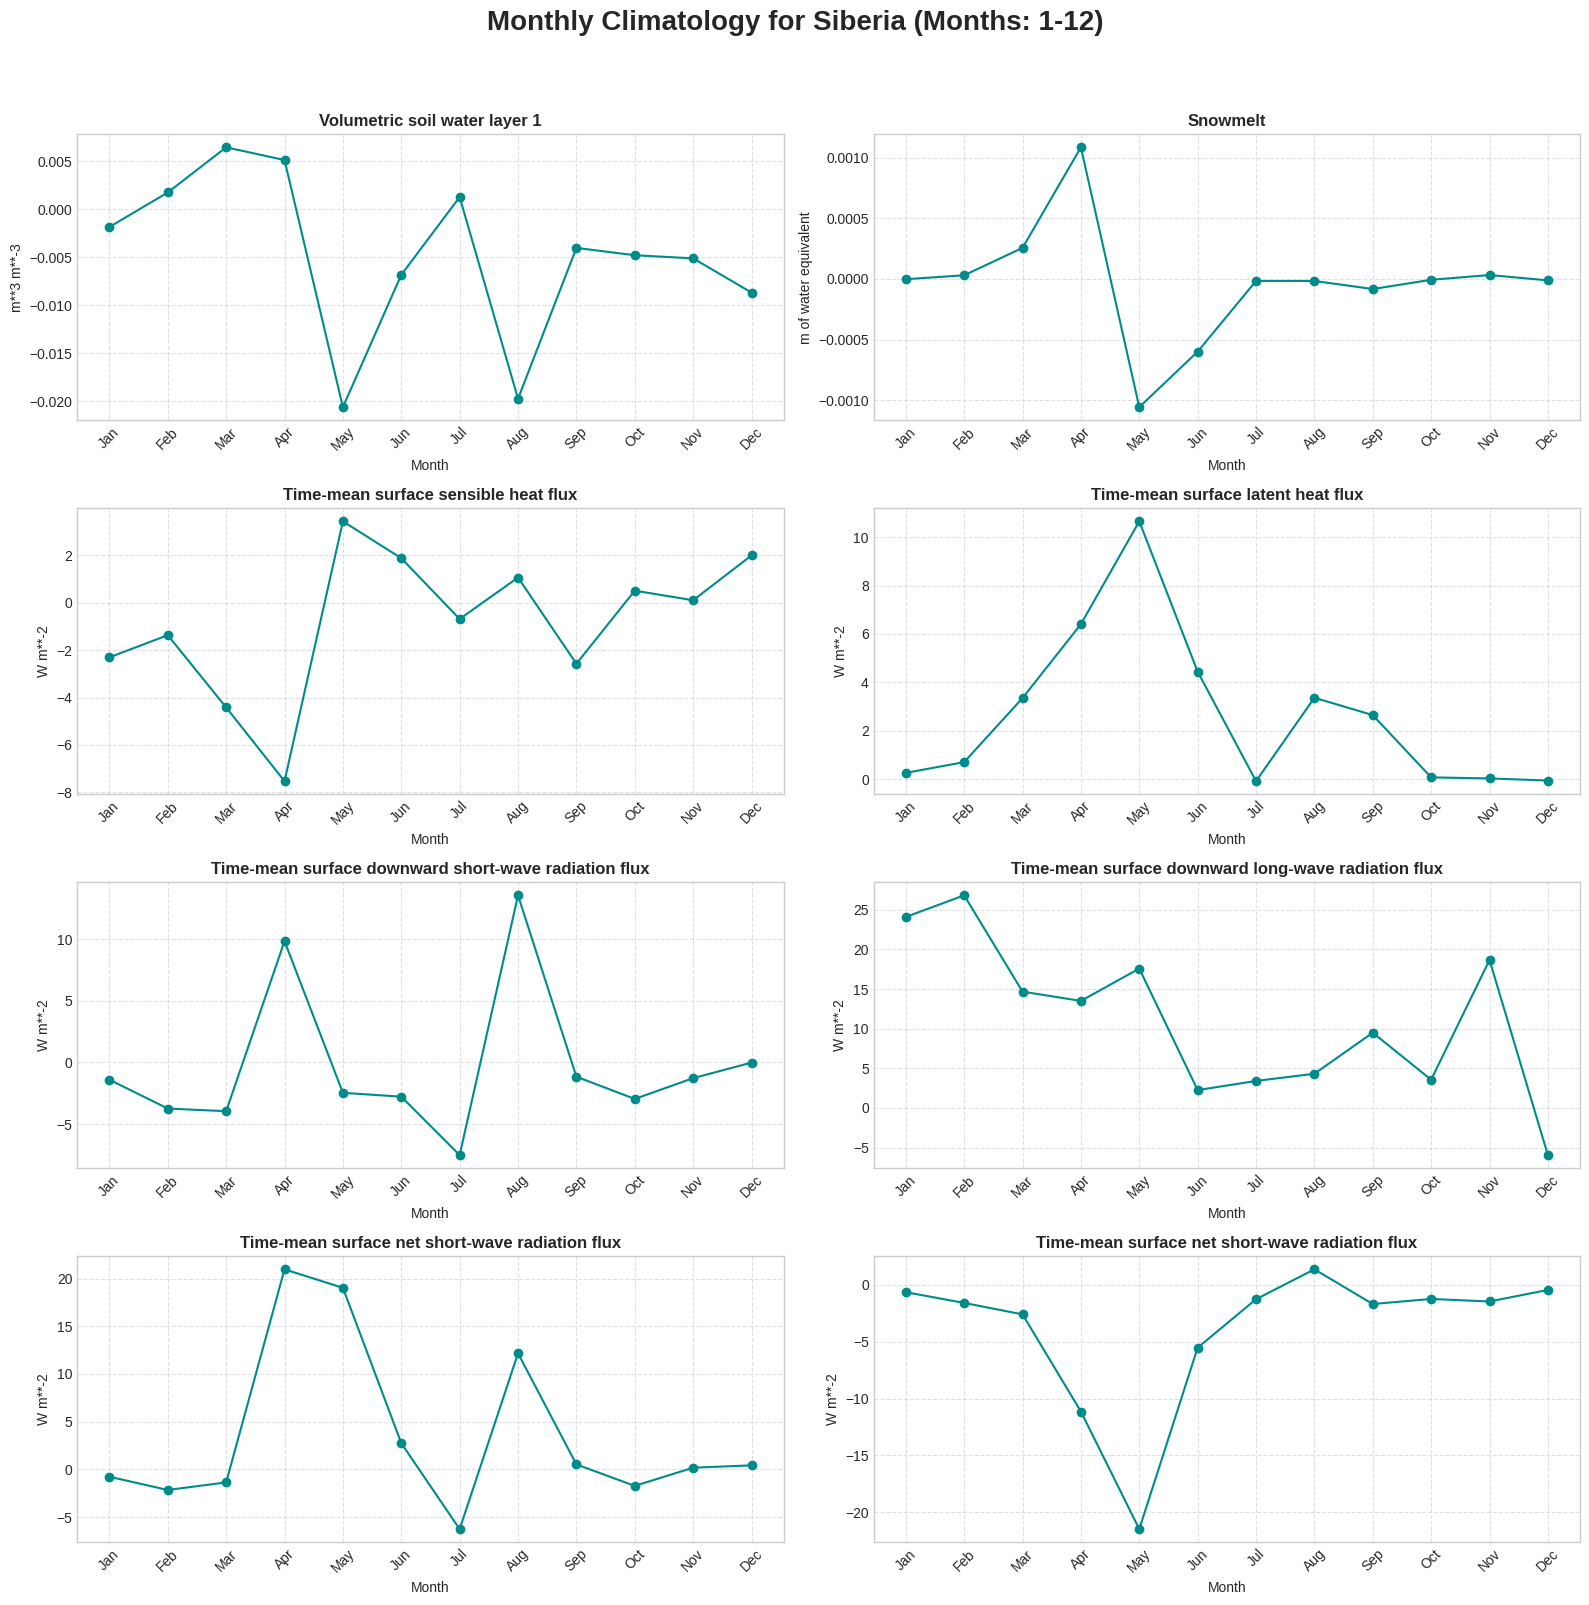

In [ ]:
# --- USER SELECTION ---
# Choose the region and time period you want to analyze here.
target_region = smg.siberia  # e.g., siberia, eurasia, arctic, or None for global
month_start = 1         # Start month (e.g., 12 for December)
month_end = 12            # End month (e.g., 2 for February)
# --- END USER SELECTION ---

# Apply the region and time selection
ds_sub = smg.select_region_and_time(
    ds,
    region=target_region,
    month_start=month_start,
    month_end=month_end
)

# --- 2. Setup the Figure and Subplots ---
num_vars = len(var_list)
ncols = 2
nrows = math.ceil(num_vars / ncols)

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 4 * nrows))
axes = axes.flatten()

# --- 3. Loop Through Variables and Plot Climatology ---
for i, var_name in enumerate(var_list):
    ax = axes[i]
    
    heatwave = ds_sub[var_name].sel(time=ds_sub.time.dt.year == 2020)
    heatwave = heatwave.weighted(weights).mean(dim=('longitude', 'latitude'))
    climatology = ds_sub[var_name].groupby('time.month').mean(dim='time')
    climatology = climatology.weighted(weights).mean(dim=('longitude', 'latitude'))
    
    long_name = climatology.attrs.get('long_name', var_name)
    units = climatology.attrs.get('units', '')

    difference = heatwave.values-climatology.values
    
    ax.plot(climatology.month, difference, marker='o', linestyle='-', color='darkcyan')
    
    ax.set_title(f'{long_name}', fontsize=12, weight='bold')
    ax.set_ylabel(f'{units}', fontsize=10)
    ax.set_xlabel('Month', fontsize=10)
    
    month_labels = [calendar.month_abbr[m] for m in climatology.month.values]
    ax.set_xticks(ticks=climatology.month.values)
    ax.set_xticklabels(month_labels, rotation=45)
    ax.grid(True, linestyle='--', alpha=0.6)

# --- 4. Final Figure Cleanup ---
for i in range(num_vars, len(axes)):
    fig.delaxes(axes[i])

# Generate a dynamic title based on the selection
region_name = target_region['name'] if target_region else "Global"
season_name = f"Months: {month_start}-{month_end}"
fig.suptitle(f'Monthly Climatology for {region_name} ({season_name})', fontsize=20, weight='bold', y=1.0)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# 2020 standardized anomaly compared to other years

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.


Text(0.5, 1.0, 'Standardized Anomaly of Siberian Latent Heat Flux')

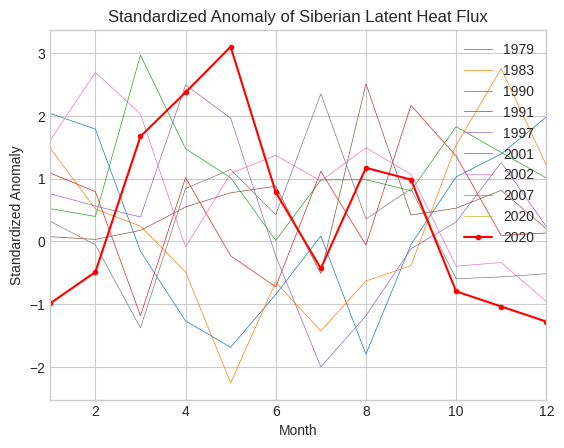

In [ ]:
# calculate where 2020 lies in the standard deviation
kwargs_allmonthssiberia = {
    "month_start": 1,
    "month_end": 12,
    "region": smg.siberia,
}

var = 'avg_slhtf'
latent_anom, latent_anom_std, latent_anom_dtrnd, latent_anom_dtrnd_std, latent_clim = smg.calculate_detrended_stats(ds, var, **kwargs_allmonthssiberia)

# standardized anom for each year w/ one month above 2 sigma
sig_count = np.zeros((len(latent_anom.resample(time='YE')),2)) # sized by number of years
for i, year in enumerate(np.arange(1979,2024)):
    ds_year = latent_anom_dtrnd_std.sel(time=str(year))
    sig_count[i,0]=len(ds_year.where(ds_year>=2,drop=True)) # count months above two sigma
    sig_count[i,1]=ds_year.time.dt.year[0] # store the year
    if sig_count[i,0]>0:
        plt.plot(ds_year.time.dt.month, ds_year,linewidth=0.5,label=str(ds_year.time.dt.year[0].values))
    else:
        pass
        # plt.plot(ds_year.time.dt.month, ds_year,linewidth=0.5, color='grey')

latent_anom_dtrnd_std_2020 = latent_anom_dtrnd_std.sel(time=str(2020))
plt.style.use('seaborn-v0_8-whitegrid')
plt.plot(latent_anom_dtrnd_std_2020.month,latent_anom_dtrnd_std_2020,'r.-',label='2020')
plt.xlabel("Month")
plt.xlim(1,12)
plt.legend()
plt.ylabel("Standardized Anomaly")
# plt.ylim(0,3)
plt.title("Standardized Anomaly of Siberian Latent Heat Flux")

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.


Text(0.5, 1.0, 'Standardized Anomaly of Siberian Sensible Heat Flux')

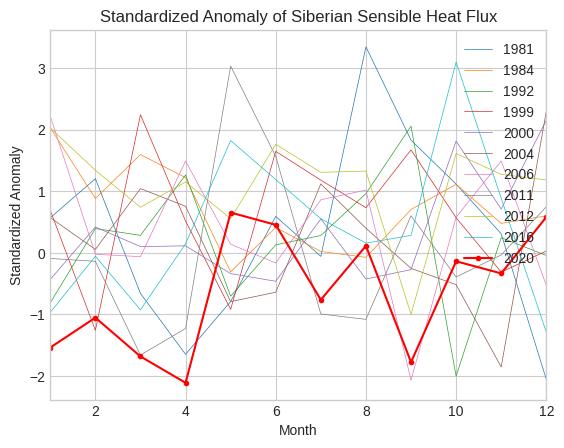

In [ ]:
# calculate where 2020 lies in the standard deviation
kwargs_allmonthseurasia = {
    "month_start": 1,
    "month_end": 12,
    "region": smg.siberia,
}

var = 'avg_ishf'
sensible_anom, sensible_anom_std, sensible_anom_dtrnd, sensible_anom_dtrnd_std, sensible_clim = smg.calculate_detrended_stats(ds, var, **kwargs_allmonthseurasia)

# standardized anom for each year w/ one month above 2 sigma
sig_count = np.zeros((len(sensible_anom.resample(time='YE')),2)) # sized by number of years
for i, year in enumerate(np.arange(1979,2024)):
    ds_year = sensible_anom_dtrnd_std.sel(time=str(year))
    sig_count[i,0]=len(ds_year.where(ds_year>=2,drop=True)) # count months above two sigma
    sig_count[i,1]=ds_year.time.dt.year[0] # store the year
    if sig_count[i,0]>0:
        plt.plot(ds_year.time.dt.month, ds_year,linewidth=0.5,label=str(ds_year.time.dt.year[0].values))
    else:
        pass

sensible_anom_dtrnd_std_2020 = sensible_anom_dtrnd_std.sel(time=str(2020))
plt.plot(sensible_anom_dtrnd_std_2020.month,sensible_anom_dtrnd_std_2020,'r.-',label='2020')
plt.xlabel("Month")
plt.xlim(1,12)
plt.legend()
plt.ylabel("Standardized Anomaly")
# plt.ylim(0,3)
plt.title("Standardized Anomaly of Siberian Sensible Heat Flux")